In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [00:19<00:00, 41.0MB/s]
100% 2.29G/2.29G [00:20<00:00, 123MB/s] 


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/chest-xray-pneumonia.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # 👈 this replaces rescale
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


In [ ]:
train_generator = train_datagen.flow_from_directory(
    '/content/chest_xray/train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    class_mode='binary',
    shuffle=True
)

val_generator = test_datagen.flow_from_directory(
    '/content/chest_xray/test',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    class_mode='binary',
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
from sklearn.utils import class_weight
import numpy as np

# Extract labels
y_train = train_generator.classes
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights_array))


In [ ]:
!pip install optuna
import optuna
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, optimizers, callbacks, regularizers
from tensorflow.keras.backend import clear_session
from tensorflow.keras.metrics import Precision, Recall

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 24.7 MB/s eta 0:00:00


In [ ]:
def objective(trial):
    clear_session()  # Reset before each trial

    # Hyperparameters
    dense_units = trial.suggest_categorical('dense_units', [128, 256, 512])
    dropout_rate = trial.suggest_float('dropout_rate', 0.3, 0.6)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)
    unfreeze_layers = trial.suggest_int('unfreeze_layers', 10, 50, step=10)
    l2_reg = trial.suggest_float('l2_reg', 1e-5, 1e-3, log=True)

    # Load base model
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = True
    for layer in base_model.layers[:-unfreeze_layers]:
        layer.trainable = False

    # Build full model
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(dense_units, kernel_regularizer=regularizers.l2(l2_reg)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(l2_reg))
    ])

    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
    )

    # Early stopping
    es = callbacks.EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True)

    # Train model
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=10,
        callbacks=[es],
        verbose=1,
        class_weight=class_weights
    )

    # Metrics
    val_acc = max(history.history['val_accuracy'])
    val_precision = max(history.history['val_precision'])
    val_recall = max(history.history['val_recall'])

    if val_precision + val_recall == 0:
        val_f1 = 0
    else:
        val_f1 = 2 * (val_precision * val_recall) / (val_precision + val_recall)

    print(f"Validation Accuracy: {val_acc:.4f}")
    print(f"Validation Precision: {val_precision:.4f}")
    print(f"Validation Recall: {val_recall:.4f}")
    print(f"Validation F1-score: {val_f1:.4f}")

    return val_f1

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)


[I 2025-06-23 08:46:24,187] A new study created in memory with name: no-name-29f9654c-5304-42b8-a7de-d8b551fe97c8


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 136s 694ms/step - accuracy: 0.9181 - loss: 0.2524 - precision: 0.9782 - recall: 0.9073 - val_accuracy: 0.9054 - val_loss: 0.4109 - val_precision: 0.9321 - val_recall: 0.9154
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 104s 637ms/step - accuracy: 0.9699 - loss: 0.1150 - precision: 0.9943 - recall: 0.9648 - val_accuracy: 0.9022 - val_loss: 0.3651 - val_precision: 0.8926 - val_recall: 0.9590
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 647ms/step - accuracy: 0.9802 - loss: 0.1046 - precision: 0.9958 - recall: 0.9773 - val_accuracy: 0.9167 - val_loss: 0.3070 - val_precision: 0.9356 - val_recall: 0.9308
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 104s 637ms/step - accuracy: 0.9810 - loss: 0.0888 - precision: 0.9969 - recall: 0.9773 - val_accuracy: 0.9231 - val_loss: 0.2978 - val_precision: 0.9233 - val_recall: 0.9564
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 104s 638ms/step - accuracy: 0.9846 - loss: 0.0889 - precision: 0.9981 - recall: 0.9813 - val_accuracy: 0

[I 2025-06-23 08:57:27,768] Trial 0 finished with value: 0.9718115410222052 and parameters: {'dense_units': 256, 'dropout_rate': 0.4049219531534122, 'learning_rate': 0.00020064092119413487, 'unfreeze_layers': 20, 'l2_reg': 9.458696144012241e-05}. Best is trial 0 with value: 0.9718115410222052.


Validation Accuracy: 0.9231
Validation Precision: 0.9770
Validation Recall: 0.9667
Validation F1-score: 0.9718
Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 130s 680ms/step - accuracy: 0.8338 - loss: 0.5691 - precision: 0.9616 - recall: 0.8065 - val_accuracy: 0.8862 - val_loss: 0.5654 - val_precision: 0.9346 - val_recall: 0.8795
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 644ms/step - accuracy: 0.9606 - loss: 0.3551 - precision: 0.9884 - recall: 0.9591 - val_accuracy: 0.9135 - val_loss: 0.5210 - val_precision: 0.9641 - val_recall: 0.8949
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 104s 638ms/step - accuracy: 0.9755 - loss: 0.3127 - precision: 0.9909 - recall: 0.9759 - val_accuracy: 0.9119 - val_loss: 0.4765 - val_precision: 0.9156 - val_recall: 0.9462
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 107s 653ms/step - accuracy: 0.9824 - loss: 0.2930 - precision: 0.9933 - recall: 0.9827 - val_accuracy: 0.8990 - val_loss: 0.5302 - val_precision: 0.8940 - val_recall: 0.9513


[I 2025-06-23 09:04:56,885] Trial 1 finished with value: 0.9576423900789369 and parameters: {'dense_units': 512, 'dropout_rate': 0.4693225086168499, 'learning_rate': 3.637194534515213e-05, 'unfreeze_layers': 30, 'l2_reg': 0.00029887598682382723}. Best is trial 0 with value: 0.9718115410222052.


Validation Accuracy: 0.9135
Validation Precision: 0.9641
Validation Recall: 0.9513
Validation F1-score: 0.9576
Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 128s 678ms/step - accuracy: 0.8054 - loss: 0.3549 - precision: 0.9503 - recall: 0.7761 - val_accuracy: 0.8702 - val_loss: 0.4715 - val_precision: 0.9783 - val_recall: 0.8103
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 104s 637ms/step - accuracy: 0.9603 - loss: 0.1285 - precision: 0.9875 - recall: 0.9584 - val_accuracy: 0.9199 - val_loss: 0.2552 - val_precision: 0.9404 - val_recall: 0.9308
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 104s 639ms/step - accuracy: 0.9738 - loss: 0.1011 - precision: 0.9935 - recall: 0.9707 - val_accuracy: 0.9183 - val_loss: 0.2938 - val_precision: 0.9593 - val_recall: 0.9077
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 103s 633ms/step - accuracy: 0.9785 - loss: 0.0853 - precision: 0.9961 - recall: 0.9750 - val_accuracy: 0.9071 - val_loss: 0.2474 - val_precision: 0.9171 - val_recall: 0.9359


[I 2025-06-23 09:12:19,612] Trial 2 finished with value: 0.9566425286776302 and parameters: {'dense_units': 128, 'dropout_rate': 0.5205894744922334, 'learning_rate': 6.177870561602347e-05, 'unfreeze_layers': 20, 'l2_reg': 4.341635488166967e-05}. Best is trial 0 with value: 0.9718115410222052.


Validation Accuracy: 0.9199
Validation Precision: 0.9783
Validation Recall: 0.9359
Validation F1-score: 0.9566
Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 131s 682ms/step - accuracy: 0.8006 - loss: 0.4394 - precision: 0.9162 - recall: 0.8048 - val_accuracy: 0.8638 - val_loss: 0.3354 - val_precision: 0.9067 - val_recall: 0.8718
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 646ms/step - accuracy: 0.9153 - loss: 0.1996 - precision: 0.9878 - recall: 0.8972 - val_accuracy: 0.8910 - val_loss: 0.3239 - val_precision: 0.9600 - val_recall: 0.8615
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 104s 638ms/step - accuracy: 0.9447 - loss: 0.1542 - precision: 0.9872 - recall: 0.9381 - val_accuracy: 0.9119 - val_loss: 0.2604 - val_precision: 0.9467 - val_recall: 0.9103
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 646ms/step - accuracy: 0.9603 - loss: 0.1237 - precision: 0.9909 - recall: 0.9558 - val_accuracy: 0.9038 - val_loss: 0.2617 - val_precision: 0.9231 - val_recall: 0.9231
Epoch 5/10
163/163 ━━━━━━━━━━━━━━

[I 2025-06-23 09:21:32,755] Trial 3 finished with value: 0.9530266103187406 and parameters: {'dense_units': 512, 'dropout_rate': 0.47433173583094024, 'learning_rate': 1.0132094962892786e-05, 'unfreeze_layers': 30, 'l2_reg': 1.819618316283717e-05}. Best is trial 0 with value: 0.9718115410222052.


Validation Accuracy: 0.9119
Validation Precision: 0.9600
Validation Recall: 0.9462
Validation F1-score: 0.9530
Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 138s 690ms/step - accuracy: 0.9305 - loss: 0.1978 - precision: 0.9749 - recall: 0.9315 - val_accuracy: 0.7772 - val_loss: 1.3112 - val_precision: 0.9665 - val_recall: 0.6667
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 652ms/step - accuracy: 0.9672 - loss: 0.1081 - precision: 0.9921 - recall: 0.9640 - val_accuracy: 0.9215 - val_loss: 0.2718 - val_precision: 0.9050 - val_recall: 0.9769
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 647ms/step - accuracy: 0.9789 - loss: 0.0794 - precision: 0.9938 - recall: 0.9776 - val_accuracy: 0.9103 - val_loss: 0.2603 - val_precision: 0.9239 - val_recall: 0.9333
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 649ms/step - accuracy: 0.9722 - loss: 0.0892 - precision: 0.9904 - recall: 0.9711 - val_accuracy: 0.9119 - val_loss: 0.2778 - val_precision: 0.9373 - val_recall: 0.9205


[I 2025-06-23 09:29:12,755] Trial 4 finished with value: 0.9717051933620411 and parameters: {'dense_units': 128, 'dropout_rate': 0.44164916813617894, 'learning_rate': 0.0004295272051470357, 'unfreeze_layers': 50, 'l2_reg': 9.657248961040389e-05}. Best is trial 0 with value: 0.9718115410222052.


Validation Accuracy: 0.9215
Validation Precision: 0.9665
Validation Recall: 0.9769
Validation F1-score: 0.9717
Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 134s 688ms/step - accuracy: 0.9044 - loss: 0.2221 - precision: 0.9794 - recall: 0.8897 - val_accuracy: 0.8590 - val_loss: 0.9049 - val_precision: 0.9494 - val_recall: 0.8179
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 646ms/step - accuracy: 0.9803 - loss: 0.0814 - precision: 0.9932 - recall: 0.9801 - val_accuracy: 0.9006 - val_loss: 0.3031 - val_precision: 0.9205 - val_recall: 0.9205
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 644ms/step - accuracy: 0.9790 - loss: 0.0726 - precision: 0.9951 - recall: 0.9768 - val_accuracy: 0.8894 - val_loss: 0.4242 - val_precision: 0.9350 - val_recall: 0.8846
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 649ms/step - accuracy: 0.9810 - loss: 0.0705 - precision: 0.9946 - recall: 0.9799 - val_accuracy: 0.9167 - val_loss: 0.3798 - val_precision: 0.9204 - val_recall: 0.9487
Epoch 5/10
163/163 ━━━━━━━━━━━━━━

[I 2025-06-23 09:44:25,594] Trial 5 finished with value: 0.9666895601079454 and parameters: {'dense_units': 256, 'dropout_rate': 0.46031961679623634, 'learning_rate': 0.00015360237353604828, 'unfreeze_layers': 40, 'l2_reg': 2.6900234478625562e-05}. Best is trial 0 with value: 0.9718115410222052.


Validation Accuracy: 0.9359
Validation Precision: 0.9494
Validation Recall: 0.9846
Validation F1-score: 0.9667
Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 127s 676ms/step - accuracy: 0.7968 - loss: 0.7571 - precision: 0.9742 - recall: 0.7399 - val_accuracy: 0.7981 - val_loss: 1.1251 - val_precision: 0.9818 - val_recall: 0.6897
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 104s 639ms/step - accuracy: 0.9673 - loss: 0.4912 - precision: 0.9929 - recall: 0.9625 - val_accuracy: 0.9022 - val_loss: 0.6943 - val_precision: 0.9410 - val_recall: 0.9000
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 104s 639ms/step - accuracy: 0.9698 - loss: 0.4595 - precision: 0.9882 - recall: 0.9705 - val_accuracy: 0.9071 - val_loss: 0.6486 - val_precision: 0.9171 - val_recall: 0.9359
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 641ms/step - accuracy: 0.9812 - loss: 0.4275 - precision: 0.9941 - recall: 0.9809 - val_accuracy: 0.9006 - val_loss: 0.5950 - val_precision: 0.8961 - val_recall: 0.9513
Epoch 5/10
163/163 ━━━━━━━━━━━━━━

[I 2025-06-23 09:57:06,648] Trial 6 finished with value: 0.9662767694704049 and parameters: {'dense_units': 256, 'dropout_rate': 0.330866081780073, 'learning_rate': 4.295104509885871e-05, 'unfreeze_layers': 20, 'l2_reg': 0.0008850561424986256}. Best is trial 0 with value: 0.9718115410222052.


Validation Accuracy: 0.9119
Validation Precision: 0.9818
Validation Recall: 0.9513
Validation F1-score: 0.9663
Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 138s 693ms/step - accuracy: 0.9082 - loss: 0.2276 - precision: 0.9668 - recall: 0.9060 - val_accuracy: 0.9183 - val_loss: 0.2804 - val_precision: 0.9248 - val_recall: 0.9462
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 107s 655ms/step - accuracy: 0.9628 - loss: 0.1002 - precision: 0.9939 - recall: 0.9553 - val_accuracy: 0.8269 - val_loss: 0.8841 - val_precision: 0.9638 - val_recall: 0.7513
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 107s 656ms/step - accuracy: 0.9801 - loss: 0.0824 - precision: 0.9939 - recall: 0.9795 - val_accuracy: 0.9071 - val_loss: 0.3060 - val_precision: 0.9256 - val_recall: 0.9256


[I 2025-06-23 10:03:01,733] Trial 7 finished with value: 0.9549031514137839 and parameters: {'dense_units': 128, 'dropout_rate': 0.43107745195088254, 'learning_rate': 0.0006860510495092892, 'unfreeze_layers': 50, 'l2_reg': 6.629386661421001e-05}. Best is trial 0 with value: 0.9718115410222052.


Validation Accuracy: 0.9183
Validation Precision: 0.9638
Validation Recall: 0.9462
Validation F1-score: 0.9549
Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 136s 692ms/step - accuracy: 0.9197 - loss: 0.2275 - precision: 0.9668 - recall: 0.9212 - val_accuracy: 0.8141 - val_loss: 1.0977 - val_precision: 0.9567 - val_recall: 0.7359
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 650ms/step - accuracy: 0.9771 - loss: 0.0827 - precision: 0.9939 - recall: 0.9754 - val_accuracy: 0.8590 - val_loss: 0.5257 - val_precision: 0.9809 - val_recall: 0.7897
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 144s 661ms/step - accuracy: 0.9764 - loss: 0.0639 - precision: 0.9919 - recall: 0.9761 - val_accuracy: 0.9006 - val_loss: 0.5522 - val_precision: 0.9432 - val_recall: 0.8949
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 649ms/step - accuracy: 0.9809 - loss: 0.0545 - precision: 0.9954 - recall: 0.9786 - val_accuracy: 0.9071 - val_loss: 0.3378 - val_precision: 0.9346 - val_recall: 0.9154
Epoch 5/10
163/163 ━━━━━━━━━━━━━━

[I 2025-06-23 10:16:42,498] Trial 8 finished with value: 0.9763220846229829 and parameters: {'dense_units': 128, 'dropout_rate': 0.4457451687133204, 'learning_rate': 0.0008800512335046147, 'unfreeze_layers': 40, 'l2_reg': 1.1470228646162759e-05}. Best is trial 8 with value: 0.9763220846229829.


Validation Accuracy: 0.9343
Validation Precision: 0.9809
Validation Recall: 0.9718
Validation F1-score: 0.9763
Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 138s 694ms/step - accuracy: 0.8941 - loss: 0.3317 - precision: 0.9725 - recall: 0.8822 - val_accuracy: 0.8974 - val_loss: 0.4691 - val_precision: 0.9382 - val_recall: 0.8949
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 107s 651ms/step - accuracy: 0.9790 - loss: 0.1641 - precision: 0.9934 - recall: 0.9782 - val_accuracy: 0.9135 - val_loss: 0.3971 - val_precision: 0.9444 - val_recall: 0.9154
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 107s 658ms/step - accuracy: 0.9821 - loss: 0.1497 - precision: 0.9945 - recall: 0.9813 - val_accuracy: 0.8894 - val_loss: 0.4557 - val_precision: 0.8575 - val_recall: 0.9872
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 107s 656ms/step - accuracy: 0.9825 - loss: 0.1418 - precision: 0.9927 - recall: 0.9836 - val_accuracy: 0.9279 - val_loss: 0.3083 - val_precision: 0.9434 - val_recall: 0.9410
Epoch 5/10
163/163 ━━━━━━━━━━━━━━

[I 2025-06-23 10:28:33,742] Trial 9 finished with value: 0.9653392053165556 and parameters: {'dense_units': 256, 'dropout_rate': 0.5859095403297231, 'learning_rate': 0.00018138168687000599, 'unfreeze_layers': 50, 'l2_reg': 0.0002168254059650183}. Best is trial 8 with value: 0.9763220846229829.


Validation Accuracy: 0.9279
Validation Precision: 0.9444
Validation Recall: 0.9872
Validation F1-score: 0.9653


In [ ]:
print("Best trial:")
print(f"  Value: {study.best_value}")  # best val_accuracy
print("  Params: ")
for key, value in study.best_params.items():
    print(f"    {key}: {value}")


Best trial:
  Value: 0.9763220846229829
  Params: 
    dense_units: 128
    dropout_rate: 0.4457451687133204
    learning_rate: 0.0008800512335046147
    unfreeze_layers: 40
    l2_reg: 1.1470228646162759e-05


In [ ]:
from tensorflow.keras import models, layers, regularizers, optimizers, metrics
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define the model with Trial 6 hyperparameters
def build_model():
    # Trial 6 hyperparameters:
    dense_units = 128
    dropout_rate = 0.4457451687133204
    learning_rate = 0.0008800512335046147
    unfreeze_layers = 40
    l2_reg = 1.1470228646162759e-05

    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
    base_model.trainable = True
    for layer in base_model.layers[:-unfreeze_layers]:
        layer.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(dense_units, kernel_regularizer=regularizers.l2(l2_reg)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(l2_reg))
    ])

    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            metrics.Precision(name='precision'),
            metrics.Recall(name='recall')
        ]
    )
    return model

# Build the model
final_model = build_model()



# Assuming train_generator and val_generator are already defined
history = final_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    class_weight=class_weights

)


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 134s 685ms/step - accuracy: 0.9153 - loss: 0.2056 - precision: 0.9629 - recall: 0.9199 - val_accuracy: 0.8942 - val_loss: 0.3478 - val_precision: 0.9355 - val_recall: 0.8923
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 648ms/step - accuracy: 0.9743 - loss: 0.0836 - precision: 0.9926 - recall: 0.9722 - val_accuracy: 0.8462 - val_loss: 0.5925 - val_precision: 0.9836 - val_recall: 0.7667
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 142s 651ms/step - accuracy: 0.9716 - loss: 0.0736 - precision: 0.9929 - recall: 0.9688 - val_accuracy: 0.8830 - val_loss: 0.3938 - val_precision: 0.8530 - val_recall: 0.9821
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 645ms/step - accuracy: 0.9790 - loss: 0.0561 - precision: 0.9920 - recall: 0.9795 - val_accuracy: 0.8830 - val_loss: 0.3998 - val_precision: 0.8530 - val_recall: 0.9821
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 649ms/step - accuracy: 0.9832 - loss: 0.0524 - precision: 0.9952 - recall: 0.9825 - val_accuracy: 0

In [ ]:
final_model.save("pneumonia_detection_model.h5")
from google.colab import files
files.download("pneumonia_detection_model.h5")
final_model.save("pneumonia_detection_model.keras", save_format="keras")
from tensorflow.keras.models import load_model

model = load_model("pneumonia_detection_model.keras")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 56 variables whereas the saved optimizer has 110 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


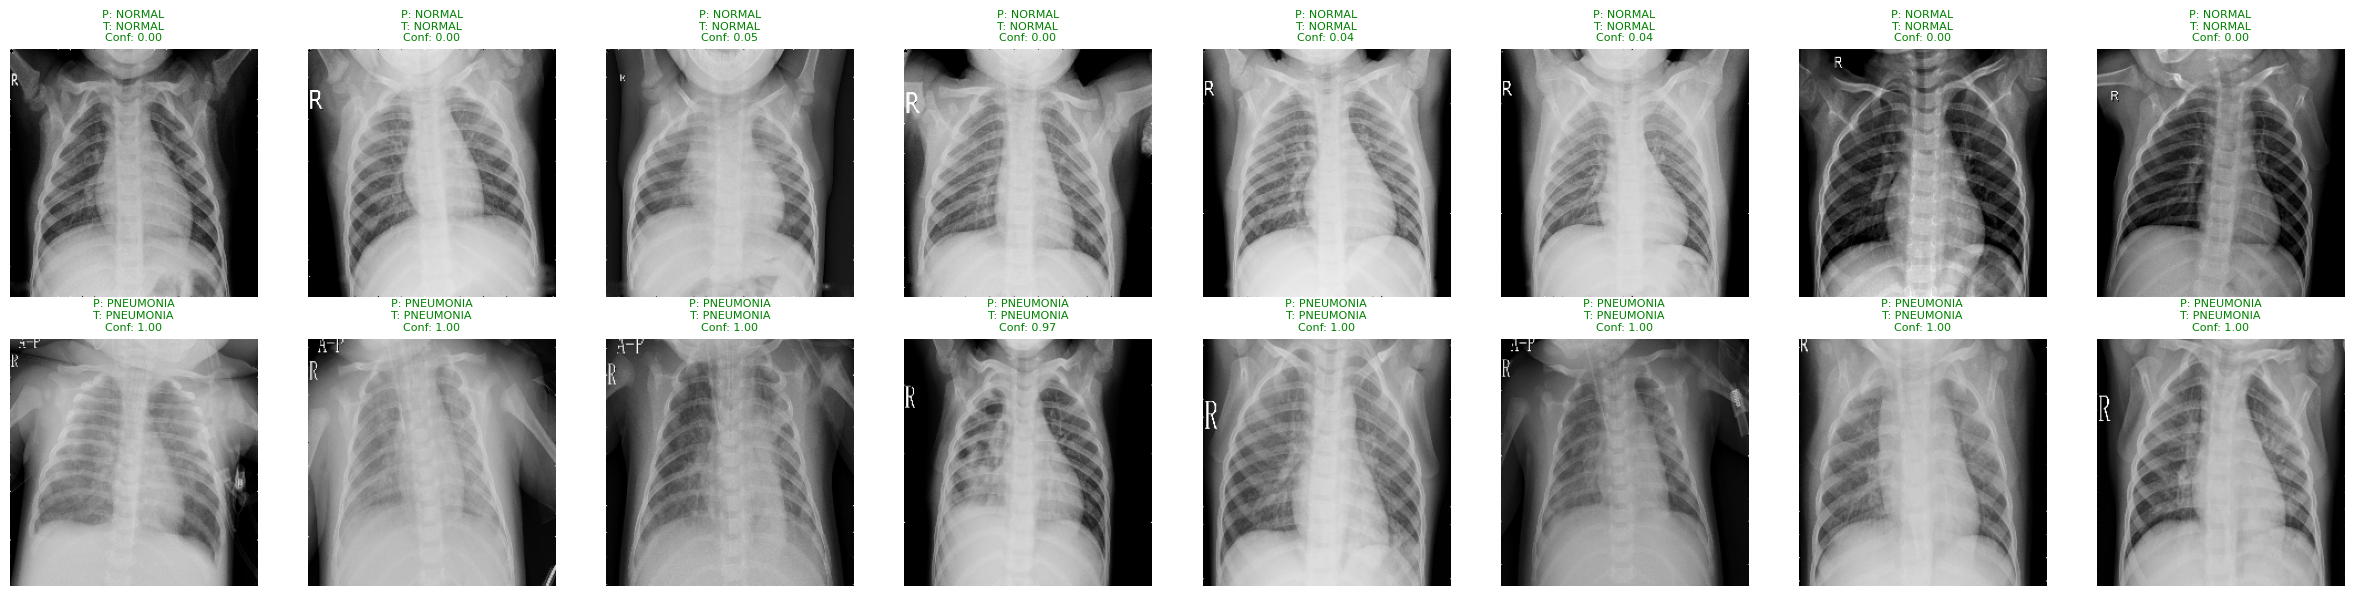

✅ Loaded 8 NORMAL and 8 PNEUMONIA images.


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import preprocess_input

# Configuration
class_names = ['NORMAL', 'PNEUMONIA']
class_to_idx = {'NORMAL': 0, 'PNEUMONIA': 1}
test_base_dir = 'chest_xray/val'  # or use 'chest_xray/test'
max_per_class = 20  # images per class

# Containers
images_to_show = []
labels_to_show = []
gray_images_for_display = []

# Load images from each class
for class_name in class_names:
    class_dir = os.path.join(test_base_dir, class_name)
    image_files = os.listdir(class_dir)
    selected_images = image_files[:min(max_per_class, len(image_files))]

    for img_name in selected_images:
        img_path = os.path.join(class_dir, img_name)

        # Read in grayscale
        gray_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if gray_img is None:
            continue  # skip broken image

        gray_img = cv2.resize(gray_img, (224, 224))

        # Convert to 3-channel RGB
        rgb_img = np.stack((gray_img,) * 3, axis=-1).astype(np.float32)

        # Preprocess for ResNet50
        preprocessed_img = preprocess_input(rgb_img)

        # Save
        images_to_show.append(preprocessed_img)
        labels_to_show.append(class_to_idx[class_name])
        gray_images_for_display.append(gray_img)

# Batch format
images_batch = np.array(images_to_show)
labels_batch = np.array(labels_to_show)

# Predict
pred_probs = final_model.predict(images_batch, verbose=0)
pred_labels = (pred_probs > 0.5).astype(int).flatten()

# Display
total_images = len(gray_images_for_display)
cols = 8
rows = (total_images + cols - 1) // cols

plt.figure(figsize=(24, rows * 3))
for i in range(total_images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(gray_images_for_display[i], cmap='gray')
    plt.axis('off')

    true = class_names[labels_batch[i]]
    pred = class_names[pred_labels[i]]
    conf = float(pred_probs[i][0])
    color = 'green' if pred_labels[i] == labels_batch[i] else 'red'
    plt.title(f"P: {pred}\nT: {true}\nConf: {conf:.2f}", color=color, fontsize=8)

plt.tight_layout()
plt.show()

# Optional: Print how many of each
print(f"✅ Loaded {labels_to_show.count(0)} NORMAL and {labels_to_show.count(1)} PNEUMONIA images.")


Saving 332aa0c67cb2e035e372c7cb3ceca2_big_gallery.jpg to 332aa0c67cb2e035e372c7cb3ceca2_big_gallery.jpg


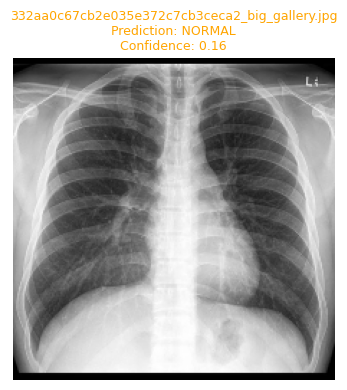

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tensorflow.keras.applications.resnet50 import preprocess_input
from google.colab import files  # ✅ Use this if you're on Google Colab

# Upload images manually
uploaded = files.upload()  # ⬅️ Opens file picker
image_paths = list(uploaded.keys())  # List of uploaded filenames

# Containers
images_to_predict = []
display_images_gray = []
image_names = []

# Preprocess uploaded images
for img_name in image_paths:
    try:
        # Read grayscale
        gray_img = cv2.imread(img_name, cv2.IMREAD_GRAYSCALE)
        if gray_img is None:
            print(f"⚠️ Skipped unreadable image: {img_name}")
            continue

        gray_img = cv2.resize(gray_img, (224, 224))

        # Convert to RGB (3-channel)
        rgb_img = np.stack((gray_img,) * 3, axis=-1).astype(np.float32)

        # Preprocess for ResNet
        preprocessed_img = preprocess_input(rgb_img)

        # Store
        images_to_predict.append(preprocessed_img)
        display_images_gray.append(gray_img)
        image_names.append(img_name)

    except Exception as e:
        print(f"❌ Error with {img_name}: {e}")

# Batch format
images_batch = np.array(images_to_predict)

# Predict
pred_probs = final_model.predict(images_batch, verbose=0)
pred_labels = (pred_probs > 0.5).astype(int).flatten()

# Class labels
class_names = ['NORMAL', 'PNEUMONIA']

# Display predictions
total_images = len(display_images_gray)
cols = 4
rows = (total_images + cols - 1) // cols

plt.figure(figsize=(20, rows * 4))
for i in range(total_images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(display_images_gray[i], cmap='gray')
    plt.axis('off')

    pred = class_names[pred_labels[i]]
    conf = float(pred_probs[i][0])
    plt.title(f"{image_names[i]}\nPrediction: {pred}\nConfidence: {conf:.2f}",
              color='green' if conf > 0.9 else 'orange', fontsize=9)

plt.tight_layout()
plt.show()
